In [1]:
%matplotlib widget
from Debye3D import Debye3D
from ase.cluster import Decahedron,Icosahedron,Octahedron
from ase.io import write
import numpy as np
from debyecalculator import DebyeCalculator
from ase.visualize import view
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter as sf

## Case of sphercial particles (isotropic case)

In the following, we consider spherical Au nanoparticles of about 3nm diameter, peridodically arranged as an fcc lattice of 3.5nm parameter. As an exercice, we will compute the SAXS image observed along the 11 zone axis of the paracrystal structure.

In real space, the structure can be ssen as the convolution of a single particle with a periodic fcc structure. We will there fore decompose our calculations as follow:
1. form factor computation $P(\vec{q})$ based on single particle calculation
2. Structure factor computation $S(\vec{q})$, based on crystal network computation

The total scattering, in reciprocal space, is therefore simply computed as
$$ I(\vec{q}) = P(\vec{q})*S(\vec{q})$$




### I. Form factor calculation

We will compare scattered intensities computed with the following methods:
- Debye 3D + detector frame integration with pyFAI
- Debye3Dd + orientational average
- Debye Caclulator (based on Debye scattering equation)
- analytic expression for the form factor of a sphere.

No significant difference is expected between these signals, as isotropic signal is expected.

1. Definition of experiment

In [2]:
file = f'./structures/Sphere_15.0.xyz' # path to structure file

# Définition de l'expérience
npix = 2000 # setup size of detector frame npix * npix
distance = 0.36 # sample to detector distance (m)
wl = 1.54 # X-ray wavelength ($\AA$)
pix_size= 0.00015 # pixel size (m)


2. Initialize Debye3D instance

In [3]:
np_scatter = Debye3D(file, Distance= distance, wl= wl, npix= npix, pixel_size= pix_size)
print(f'Structure contains {np_scatter.nb_atoms} atoms')


----------------------------------------------------
 Detector configuration / accessible Q-range
----------------------------------------------------
 Wavelength λ = 1.5400 Å
 Sample-detector distance = 360.00 mm
 Pixel size = 0.150 mm
 Number of pixels = 2000 x 2000

 Qx range : -1.5692 → 1.5679 Å⁻¹
 Qy range : -0.5649 → 0.0000 Å⁻¹
 Qz range : -1.5692 → 1.5679 Å⁻¹
 |Q| range : 0.0000 → 2.1469 Å⁻¹
----------------------------------------------------

Structure contains 887 atoms


3. Compute intensity using DebyeCalculator (orientaional averaging)

In [4]:
q_dc, i_dc = np_scatter.compute_Iq_debyecalc()

/home-local/ratel-ra/Documents/Python_code/Debye_3D/Debye3D.py:301: UserWarning: Warning: Your system might have a CUDA-enabled GPU, but CUDA is not available. Computations will run on the CPU instead. For optimal performance, please install Pytorch with CUDA support. If you do not have a CUDA-enabled GPU, you can surpress this warning by specifying the 'device' argument as 'cpu'
  calc = DebyeCalculator(qmin=self.q_min, qmax=self.q_max, qstep=qstep, biso=0, device='cuda')


4. Compute intesity projected on the detector frame (x,z) plane

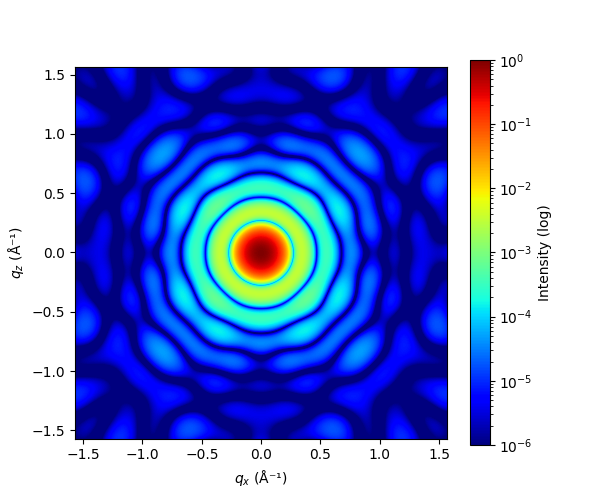

In [5]:
I_map=np_scatter.compute_intensity()
np_scatter.plot_intensity(I_map,vmin=-6)

5. Integrate detector frame with pyFAI

In [6]:
q,i = np_scatter.integrate_with_pyfai(I_map)


  File "/home-local/ratel-ra/Documents/Python_code/Debye_3D/Debye3D.py", line 528, in ai
    ai = AzimuthalIntegrator(dist=self.D, detector=detector)


6. Compute orientational average

In [7]:
q_iso, i_iso = np_scatter.compute_isotropic_intensity_fibonacci(npoints = 500)

7. Compute analytic solution of spherical form factor



$I(q)= |N*f_0*F(q)|^2$ where $F(q)=3\frac{sin(qR)-qRcos(qR)}{(qR)^3}$

In [8]:
def saxs_sphere(q, R):
    qR = q * R
    # handle q=0 to avoid division by zero
    Fq = np.ones_like(qR)
    nonzero = qR != 0
    Fq[nonzero] = 3 * (np.sin(qR[nonzero]) - qR[nonzero] * np.cos(qR[nonzero])) / (qR[nonzero]**3)
    return Fq

def saxs_sphere_intensity(q, R):
    """
    Compute the SAXS intensity for a homogeneous sphere: I(q) = |f*F(q)|^2
    """
    Fq = saxs_sphere(q, R)
    return np.abs(Fq)**2*np_scatter.xray_f0(np_scatter.elements[0],q)**2*np_scatter.nb_atoms**2

q_th = np.linspace(np_scatter.q_min,np_scatter.q_max,500)
i_th=saxs_sphere_intensity(q_th,14.985)  # true radius of the sphere is 14.985 (not 15)

7. Plot results for comparison

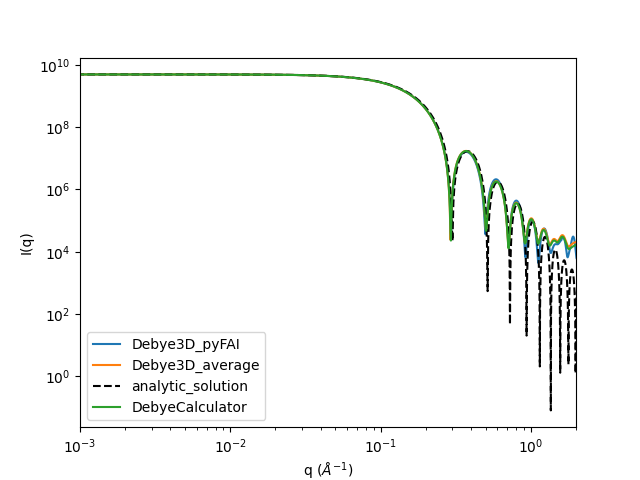

In [9]:
plt.figure()
plt.loglog(q,i,label='Debye3D_pyFAI')
plt.loglog(q_iso,i_iso,label='Debye3D_average')
plt.loglog(q_th,i_th,'--k',label='analytic_solution')
plt.loglog(q_dc, i_dc,label = 'DebyeCalculator')
plt.xlabel('q ($\AA^{-1}$)')
plt.xlim(0.001,2)
plt.ylabel('I(q)')
plt.legend()

For memory, we save the number of atoms and f as variables, to be further used for structure factor computation


In [10]:
nb_atoms = np_scatter.nb_atoms
Z= np_scatter.xray_f0(np_scatter.elements[0],0) #= Z for simplicity

### II. Structure factor calculation

We wil use functions defined in generate_paracrystal_assembly to build supercelle of paracrystals.

In this example we will assume fcc lattice of spherical particles (SG #255) a=3.5nm,
We wil simulate a zone axis 110 obtained by  rotations of 45° around z axes.

1. Lattice generation

In [15]:
from generate_paracrystal_assembly import *
# fcc assembly, SG = Fm-3m #225 (a = 3.5nm)
structure_file = generate_supercell([35,35, 35, 90,90,90], spacegroup=225, supercell_size=(20,20,20))



Supermaille générée : supercell.xyz (32000 atomes)


2. Structure rotation to obtaine zone axis [111]

We will use the method rotate_positions implemented in Debye3D class.
By default the zone axis is 010. We therefore perform a single rotation of 45° each around z to get 110 zone axis.

In [16]:
# initialization of Debye3D class
np_scatter = Debye3D(structure_file, Distance= distance, wl= wl, npix= npix, pixel_size= pix_size)
np_scatter.positions = np_scatter.rotate_positions(0,0,45)

----------------------------------------------------
 Detector configuration / accessible Q-range
----------------------------------------------------
 Wavelength λ = 1.5400 Å
 Sample-detector distance = 360.00 mm
 Pixel size = 0.150 mm
 Number of pixels = 2000 x 2000

 Qx range : -1.5692 → 1.5679 Å⁻¹
 Qy range : -0.5649 → 0.0000 Å⁻¹
 Qz range : -1.5692 → 1.5679 Å⁻¹
 |Q| range : 0.0000 → 2.1469 Å⁻¹
----------------------------------------------------



3. Compute structure factor

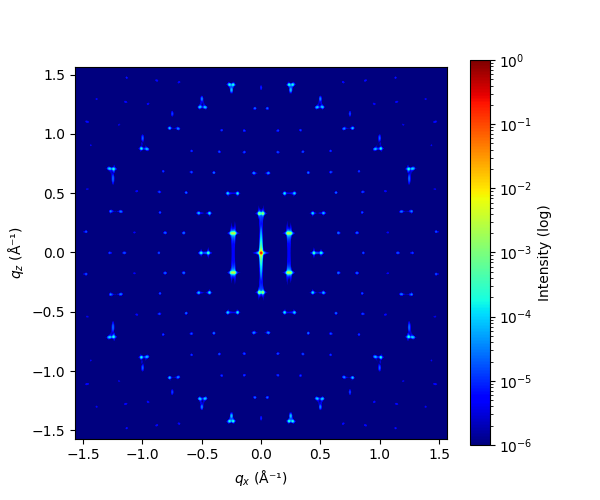

In [17]:

I_stru = np_scatter.compute_structure_factor(nb_atoms,Z)
np_scatter.plot_intensity(I_stru,vmin=-6)

### III. Computation of resulting SAXS image



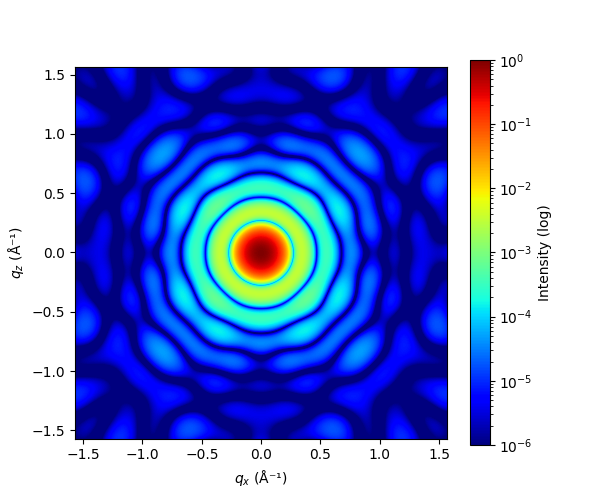

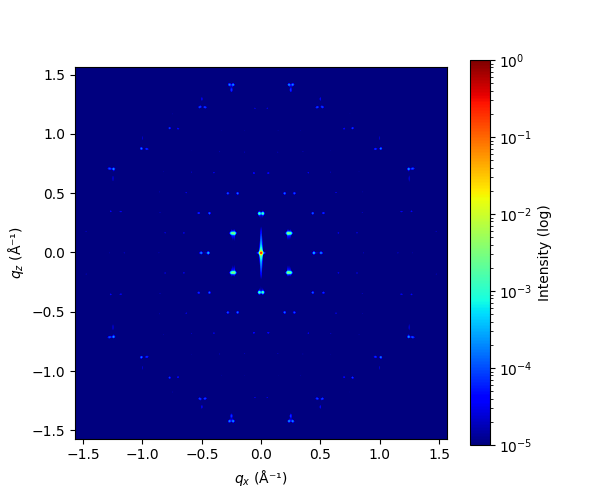

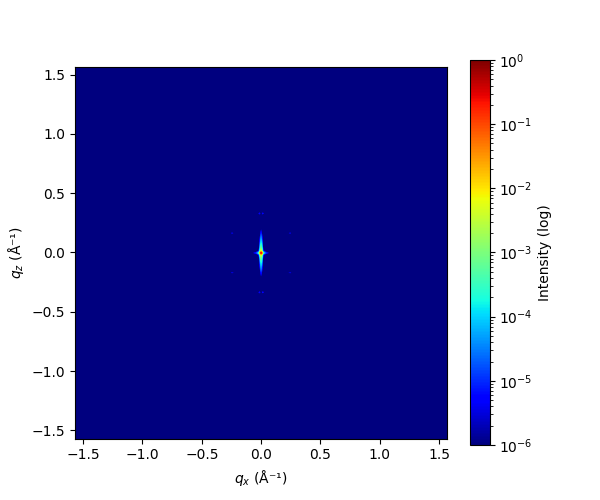

In [20]:
np_scatter.plot_intensity(I_map,vmin=-6)
np_scatter.plot_intensity(I_stru,vmin=-5)
np_scatter.plot_intensity(I_map*I_stru,vmin=-6)